# Reproduction of FSL's course example on fluency_task dataset using FEAT

The pipelines were adapted on a dataset downloadable [**here**](https://fsl.fmrib.ox.ac.uk/fslcourse/#Data). 
These data & script reproduce the [**Section 3 practical session**](https://fsl.fmrib.ox.ac.uk/fslcourse/lectures/practicals/feat1/index.html) of the FSL course.

To use the notebooks, create a docker container using the instructions in the file and use the parent repository of **"analytic_variability_fmri"** as a volume. The dataset should be downloaded in a repository named **"fluency_task"** in the directory **"data"** inside this repository. 
Otherwise, if you want to use different paths, you need to update these paths on the notebooks. 

This notebook is separated into **2 parts** : 
* Preprocessing
* 1st level analysis 

The first part can be run by its own but the 1st level analysis require that the preprocessing was already run. 

In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os as os
import json
from nipype.interfaces.fsl import (BET, FLIRT, ImageMaths, MCFLIRT, Level1Design, FEATModel, FILMGLS)
from nipype.algorithms.modelgen import SpecifyModel
from nipype.interfaces.spm import Smooth
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

from nipype import config

In [2]:
from nipype.interfaces import spm
matlab_cmd = '/opt/spm12-r7771/run_spm12.sh /opt/matlabmcr-2010a/v713/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

In [3]:
## Useful paths
exp_dir = '/home/analytic_variability_fmri/data/fluency_task'
working_dir = 'workingdir_fsl'
output_dir = 'datasink_fsl'

In [4]:
## Useful values
TR = 4.2

iso_size = 4

fwhm = 7

In [5]:
contrasts = [('Generation', 'T', ['Generation', 'Shadowing'], [1, 0]),
            ('Shadowing', 'T', ['Generation', 'Shadowing'], [0, 1]),
            ('Mean', 'T', ['Generation', 'Shadowing'], [1, 1]),
            ('Shadowing > Generation', 'T', ['Generation', 'Shadowing'], [-1, 1]),
            ('Generation > Shadowing', 'T', ['Generation', 'Shadowing'], [1, -1])]

In [6]:
## Templates for select_files node
func_file = opj(exp_dir, 'fmri.nii.gz')

anat_file = opj(exp_dir, 'structural.nii.gz')

mni_file = '/opt/fsl-6.0.3/data/standard/MNI152_T1_2mm_brain.nii.gz'

templates = {'anat' : anat_file, 'func' : func_file, 'mni' : mni_file}

In [7]:
# SelectFiles 
selectfiles = Node(SelectFiles(templates, base_directory = exp_dir), name = 'selectfiles')

# Datasink node : to save important files 
datasink = Node(DataSink(base_directory = exp_dir,
                        container = output_dir), name = 'datasink')

In [8]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FLIRT - pre-alignment of mean functional image to anatomical images
coreg_pre = Node(FLIRT(dof=7, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of pre-aligned mean functional image to standard image
coreg = Node(FLIRT(dof=12, output_type='NIFTI_GZ'),
                 name="coreg")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(no_resample=True,
                           apply_isoxfm=iso_size,
                           output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(apply_isoxfm=iso_size,
                                output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(exp_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (coreg_pre, coreg, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')])
                 ])

In [9]:
# MCFLIRT - Motion correction
motion_correction = Node(MCFLIRT(mean_vol=True), name = 'motion_correction')

# Smooth - smoothing of the image
smooth = Node(spm.Smooth(fwhm = 7), name = 'smooth')

In [10]:
# Preprocess workflow 
preprocess = Workflow(base_dir = opj(exp_dir, working_dir), name = 'preprocess')

preprocess.connect([(selectfiles, motion_correction, [('func', 'in_file')]),
                   (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                          ('mni', 'coreg.reference')]),
                   (motion_correction, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                                 ('mean_img', 'coreg.in_file'),
                                                ('mean_img', 'applywarp_mean.in_file'),
                                                ('out_file', 'applywarp.in_file')]),
                    (coregwf, smooth, [('applywarp.out_file', 'in_files')]),
                    (smooth, datasink, [('smoothed_files', 'preprocess.@smoothed')])
                   ])

210221-11:09:05,441 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/fluency_task/workingdir_fsl/preprocess/graph.png (graph2use=colored, simple_form=True).


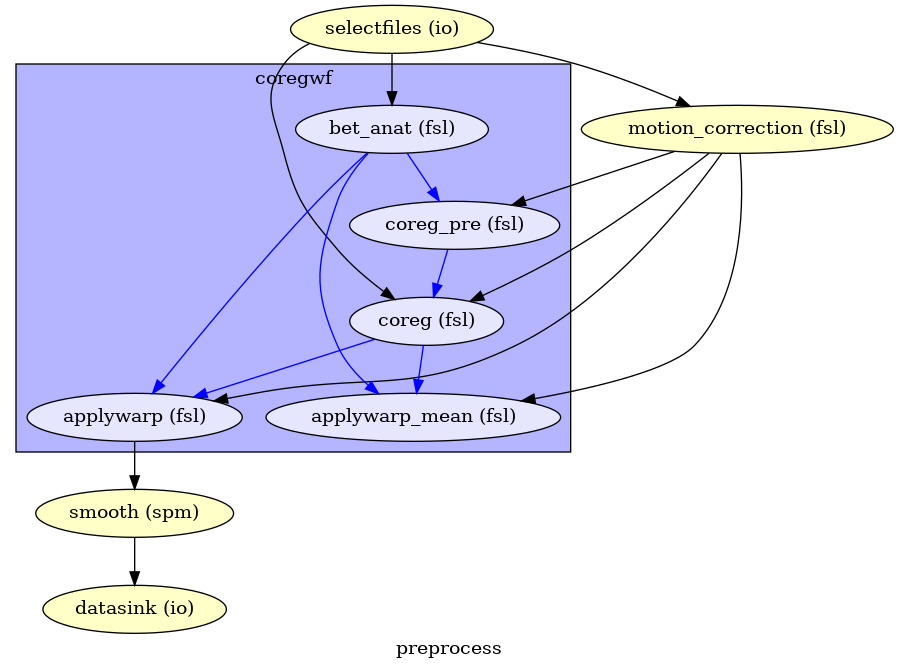

In [11]:
# Create preprocess output graph
preprocess.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preprocess.base_dir, 'preprocess', 'graph.png'))

In [12]:
preprocess.run()

210221-11:09:06,289 nipype.workflow INFO:
	 Workflow preprocess settings: ['check', 'execution', 'logging', 'monitoring']
210221-11:09:06,297 nipype.workflow INFO:
	 Running serially.
210221-11:09:06,298 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.selectfiles" in "/home/analytic_variability_fmri/data/fluency_task/workingdir_fsl/preprocess/selectfiles".
210221-11:09:06,301 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210221-11:09:06,306 nipype.workflow INFO:
	 [Node] Finished "preprocess.selectfiles".
210221-11:09:06,307 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coregwf.bet_anat" in "/home/analytic_variability_fmri/data/fluency_task/workingdir_fsl/preprocess/coregwf/bet_anat".
210221-11:09:06,311 nipype.workflow INFO:
	 [Node] Running "bet_anat" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /home/analytic_variability_fmri/data/fluency_task/structural.nii.gz /home/analytic_variability

## END OF THE PREPROCESSING PIPELINE 

## BEGINNING OF ANALYSIS PIPELINE

In [13]:
## Templates for selectfiles node 
templates = {'smooth' : opj(output_dir, 'preprocess', 'sfmri_mcf_flirt.nii')}

selectfiles_analysis = Node(SelectFiles(templates, base_directory = exp_dir), name = 'selectfiles_analysis')

datasink_analysis = Node(DataSink(base_directory = exp_dir, container=output_dir), name = 'datasink_analysis') 

In [14]:
## GENERATE SUBJECT INFO 
import pandas as pd
from nipype.interfaces.base import Bunch 

word_gen = pd.read_table('/home/analytic_variability_fmri/data/fluency_task/word_generation.txt', header=None, 
                         names = ['onset', 'duration', 'amplitude'], index_col=False)

word_shad = pd.read_table('/home/analytic_variability_fmri/data/fluency_task/word_shadowing.txt', header=None, 
                         names = ['onset', 'duration', 'amplitude'], index_col=False)

conditions = ['Generation', "Shadowing"]
word_generation_onsets = word_gen.onset.tolist()
word_generation_durations = word_gen.duration.tolist()
word_shadowing_onsets = word_shad.onset.tolist()
word_shadowing_durations = word_shad.duration.tolist()

subject_info = [Bunch(conditions = conditions, durations = [word_generation_durations, word_shadowing_durations], 
                     onsets = [word_generation_onsets, word_shadowing_onsets])]

In [15]:
# SPECIFY MODEL
specify_model = Node(SpecifyModel(high_pass_filter_cutoff = 128,
                                 input_units = 'secs', 
                                 subject_info = subject_info,
                                 time_repetition = TR), name = 'specify_model')

# DESIGN MODEL
l1_design = Node(Level1Design(bases = {'dgamma':{'derivs' : True}},
                             interscan_interval = TR, 
                             model_serial_correlations = True,
                             contrasts = contrasts), name = 'l1_design')

# GENERATE MODEL
model_generation = Node(FEATModel(), name = 'model_generation')

# ESTIMATE MODEL
model_estimate = Node(FILMGLS(smooth_autocorr=True, mask_size=5, threshold=1000),
    name='model_estimate')

In [16]:
## CREATION OF SINGLE SUBJECT ANALYSIS WORKFLOW
single_subject_analysis = Workflow(base_dir = opj(exp_dir, working_dir), 
                                   name = 'single_subject_analysis')

single_subject_analysis.connect([(specify_model, l1_design, [('session_info', 'session_info')]),
                                (l1_design, model_generation, [('fsf_files', 'fsf_file'),
                                                              ('ev_files', 'ev_files')]),
                                 (model_generation, model_estimate, [('design_file', 'design_file')]),
                                 (selectfiles_analysis, specify_model, [('smooth', 'functional_runs')]),
                                 (selectfiles_analysis, model_estimate, [('smooth', 'in_file')]),
                                  (model_generation, datasink_analysis, [('design_image', 'results@img'),
                                                                      ('con_file', 'results@con_file')]),
                                  (model_estimate, datasink_analysis, [('results_dir', 'results@estimate')])
                                ])

210221-11:10:33,875 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/fluency_task/workingdir_fsl/single_subject_analysis/graph.png (graph2use=colored, simple_form=True).


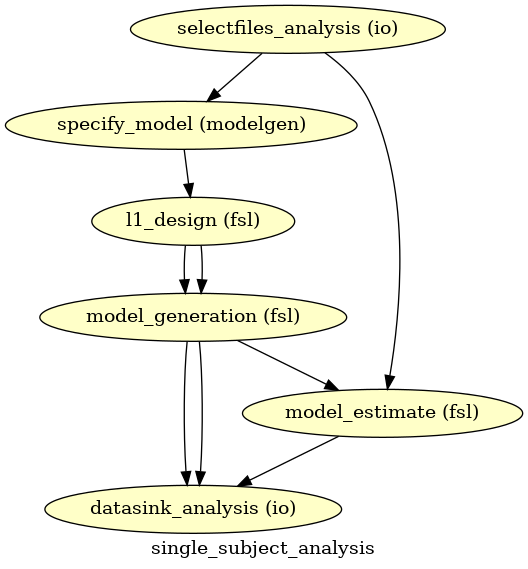

In [17]:
# Create single_subject_analysis output graph
single_subject_analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(single_subject_analysis.base_dir, 'single_subject_analysis', 'graph.png'))

In [18]:
single_subject_analysis.run()

210221-11:10:34,434 nipype.workflow INFO:
	 Workflow single_subject_analysis settings: ['check', 'execution', 'logging', 'monitoring']
210221-11:10:34,443 nipype.workflow INFO:
	 Running serially.
210221-11:10:34,444 nipype.workflow INFO:
	 [Node] Setting-up "single_subject_analysis.selectfiles_analysis" in "/home/analytic_variability_fmri/data/fluency_task/workingdir_fsl/single_subject_analysis/selectfiles_analysis".
210221-11:10:34,447 nipype.workflow INFO:
	 [Node] Running "selectfiles_analysis" ("nipype.interfaces.io.SelectFiles")
210221-11:10:34,452 nipype.workflow INFO:
	 [Node] Finished "single_subject_analysis.selectfiles_analysis".
210221-11:10:34,453 nipype.workflow INFO:
	 [Node] Setting-up "single_subject_analysis.specify_model" in "/home/analytic_variability_fmri/data/fluency_task/workingdir_fsl/single_subject_analysis/specify_model".
210221-11:10:34,460 nipype.workflow INFO:
	 [Node] Running "specify_model" ("nipype.algorithms.modelgen.SpecifyModel")
210221-11:10:34,466 n